In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
import os

In [3]:
patient_diag = pd.read_csv('./Respiratory_Sound_Database/patient_diagnosis.csv', names=['pid', 'disease'])
patient_diag.head()

,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [4]:
def getFilenameInfo(file):
    return file.split('_')

In [5]:
path='./Respiratory_Sound_Database/audio_and_txt_files/'
files=[s.split('.')[0] for s in os.listdir(path) if '.txt' in s]
files[:5]

['126_1b1_Al_sc_Meditron',
 '148_1b1_Al_sc_Meditron',
 '130_1p3_Pl_mc_AKGC417L',
 '205_3b4_Ar_mc_AKGC417L',
 '174_1p2_Pr_mc_AKGC417L']

In [6]:
files_data=[]
for file in files:
    data=pd.read_csv(path + file + '.txt',sep='\t',names=['start','end','crackles','weezels'])
    name_data=getFilenameInfo(file)
    data['pid']=name_data[0]
    data['mode']=name_data[-2]
    data['filename']=file
    files_data.append(data)
files_df=pd.concat(files_data)
files_df.reset_index()
files_df.head()

,start,end,crackles,weezels,pid,mode,filename
0,0.022,0.422,0,0,126,sc,126_1b1_Al_sc_Meditron
1,0.422,2.136,0,0,126,sc,126_1b1_Al_sc_Meditron
2,2.136,3.779,0,0,126,sc,126_1b1_Al_sc_Meditron
3,3.779,5.836,0,0,126,sc,126_1b1_Al_sc_Meditron
4,5.836,7.850,0,0,126,sc,126_1b1_Al_sc_Meditron


In [7]:
patient_diag.pid=patient_diag.pid.astype('int32')
files_df.pid=files_df.pid.astype('int32')
data=pd.merge(files_df,patient_diag,on='pid')
data.head()

,start,end,crackles,weezels,pid,mode,filename,disease
0,0.022,0.422,0,0,126,sc,126_1b1_Al_sc_Meditron,Healthy
1,0.422,2.136,0,0,126,sc,126_1b1_Al_sc_Meditron,Healthy
2,2.136,3.779,0,0,126,sc,126_1b1_Al_sc_Meditron,Healthy
3,3.779,5.836,0,0,126,sc,126_1b1_Al_sc_Meditron,Healthy
4,5.836,7.850,0,0,126,sc,126_1b1_Al_sc_Meditron,Healthy


In [9]:
# os.makedirs('csv_data')
data.to_csv('csv_data/data.csv',index=False)

In [10]:
def getPureSample(raw_data,start,end,sr=22050):
    '''
    Takes a numpy array and spilts its using start and end args
    
    raw_data=numpy array of audio sample
    start=time
    end=time
    sr=sampling_rate
    mode=mono/stereo
    
    '''
    max_ind = len(raw_data) 
    start_ind = min(int(start * sr), max_ind)
    end_ind = min(int(end * sr), max_ind)
    return raw_data[start_ind: end_ind]

<AxesSubplot:ylabel='pid'>

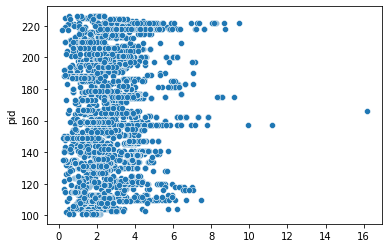

In [11]:
sns.scatterplot(x=(data.end-data.start), y=data.pid, )

<AxesSubplot:>

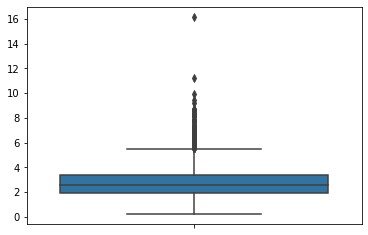

In [12]:
sns.boxplot(y=(data.end-data.start))

In [14]:
# os.makedirs('processed_audio_files')
for index,row in data.iterrows():
    print("Index ->",index)
    print("Data->\n",row)
    break

Index -> 0
Data->
 start                        0.022
end                          0.422
crackles                         0
weezels                          0
pid                            126
mode                            sc
filename    126_1b1_Al_sc_Meditron
disease                    Healthy
Name: 0, dtype: object


In [ ]:
import librosa as lb
import soundfile as sf
from tqdm import tqdm
i,c=0,0
for index,row in tqdm(data.iterrows()):
    maxLen=6
    start=row['start']
    end=row['end']
    filename=row['filename']
    
    #If len > maxLen , change it to maxLen
    if end-start>maxLen:
        end=start+maxLen
    
    audio_file_loc=path + filename + '.wav'
    
    if index > 0:
        #check if more cycles exits for same patient if so then add i to change filename
        if data.iloc[index-1]['filename']==filename:
            i+=1
        else:
            i=0
    filename= filename + '_' + str(i) + '.wav'
    
    save_path='processed_audio_files/' + filename
    c+=1
    
    audioArr,sampleRate=lb.load(audio_file_loc)
    pureSample=getPureSample(audioArr,start,end,sampleRate)
    
    #pad audio if pureSample len < max_len
    reqLen=6*sampleRate
    padded_data = lb.util.pad_center(pureSample, reqLen)
    
    sf.write(file=save_path,data=padded_data,samplerate=sampleRate)
print('Total Files Processed: ',c)

In [16]:
diagnosis=pd.read_csv('./Respiratory_Sound_Database/patient_diagnosis.csv',names=['pid','disease'])
diagnosis.head()

,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


/home/gurnameh/dev/MLproj/housing_model/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'URTI'),
  Text(1, 0, 'Healthy'),
  Text(2, 0, 'Asthma'),
  Text(3, 0, 'COPD'),
  Text(4, 0, 'LRTI'),
  Text(5, 0, 'Bronchiectasis'),
  Text(6, 0, 'Pneumonia'),
  Text(7, 0, 'Bronchiolitis')])

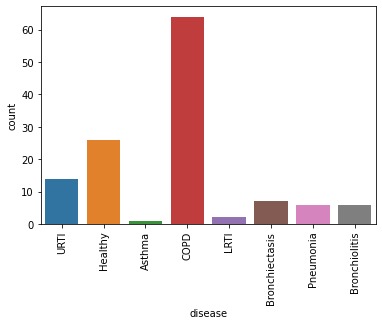

In [17]:
sns.countplot(diagnosis.disease)
plt.xticks(rotation=90)

In [18]:
def extractId(filename):
    return filename.split('_')[0]

In [19]:
path='./processed_audio_files/'
length=len(os.listdir(path))
index=range(length)
i=0
files_df=pd.DataFrame(index=index,columns=['pid','filename'])
file_list = os.listdir(path)
for f in tqdm(file_list):
    files_df.iloc[i]['pid']=extractId(f)
    files_df.iloc[i]['filename']=f
    i+=1
files_df.head()

100%|██████████| 6898/6898 [00:00<00:00, 7946.98it/s]


,pid,filename
0,204,204_7p5_Tc_mc_AKGC417L_0.wav
1,130,130_1p4_Pl_mc_AKGC417L_2.wav
2,174,174_1p3_Ll_mc_AKGC417L_0.wav
3,104,104_1b1_Ll_sc_Litt3200_0.wav
4,201,201_1b2_Ar_sc_Meditron_3.wav


In [20]:
files_df.pid=files_df.pid.astype('int64') # both pid's must be of same dtype for them to merge
data=pd.merge(files_df,diagnosis,on='pid')
data.head()

,pid,filename,disease
0,204,204_7p5_Tc_mc_AKGC417L_0.wav,COPD
1,204,204_7p5_Pr_mc_AKGC417L_0.wav,COPD
2,204,204_7p5_Ll_mc_AKGC417L_2.wav,COPD
3,204,204_7p5_Lr_mc_AKGC417L_6.wav,COPD
4,204,204_7p5_Ar_mc_AKGC417L_2.wav,COPD


/home/gurnameh/dev/MLproj/housing_model/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'COPD'),
  Text(1, 0, 'Bronchiectasis'),
  Text(2, 0, 'URTI'),
  Text(3, 0, 'Healthy'),
  Text(4, 0, 'Pneumonia'),
  Text(5, 0, 'Bronchiolitis'),
  Text(6, 0, 'LRTI'),
  Text(7, 0, 'Asthma')])

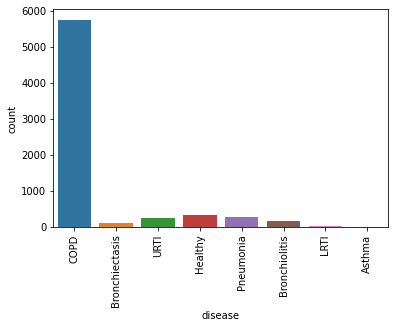

In [21]:
sns.countplot(data.disease)
plt.xticks(rotation=90)

In [22]:
from sklearn.model_selection import train_test_split
Xtrain,Xval,ytrain,yval=train_test_split(data,data.disease,stratify=data.disease,random_state=42,test_size=0.25)

In [23]:
Xtrain.disease.value_counts()/Xtrain.shape[0]

COPD              0.832979
Healthy           0.046588
Pneumonia         0.041369
URTI              0.035183
Bronchiolitis     0.023197
Bronchiectasis    0.015078
LRTI              0.004639
Asthma            0.000967
Name: disease, dtype: float64

In [24]:
Xtrain.disease.value_counts()/Xtrain.shape[0]

COPD              0.833043
Healthy           0.046957
Pneumonia         0.041159
URTI              0.035362
Bronchiolitis     0.023188
Bronchiectasis    0.015072
LRTI              0.004638
Asthma            0.000580
Name: disease, dtype: float64

[Text(0.5, 1.0, 'MFCC')]

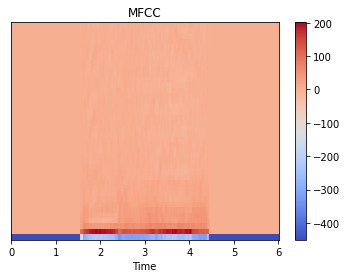

In [25]:
path='./processed_audio_files/'

import librosa.display
file=path + Xtrain.iloc[193].filename 
sound,sample_rate=lb.load(file)
mfccs = lb.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=40)
fig, ax = plt.subplots()
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')

In [26]:
Xtrain.to_csv('train.csv')
Xval.to_csv('val.csv')

In [27]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import librosa.display as lbd

In [28]:
train=pd.read_csv('./train.csv')
val=pd.read_csv('./val.csv')
train.head()

,Unnamed: 0,pid,filename,disease
0,1454,198,198_1b5_Lr_mc_AKGC417L_6.wav,COPD
1,5815,159,159_1b1_Pr_sc_Meditron_5.wav,Healthy
2,473,130,130_3b4_Ar_mc_AKGC417L_4.wav,COPD
3,6314,127,127_1b1_Ar_sc_Meditron_5.wav,Healthy
4,1253,203,203_1p2_Tc_mc_AKGC417L_3.wav,COPD


In [29]:
ytrain=train.disease
yval=val.disease
yval

0       COPD
1       COPD
2       COPD
3       COPD
4       COPD
        ... 
1720    COPD
1721    COPD
1722    COPD
1723    COPD
1724    COPD
Name: disease, Length: 1725, dtype: object

/home/gurnameh/dev/MLproj/housing_model/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='disease', ylabel='count'>

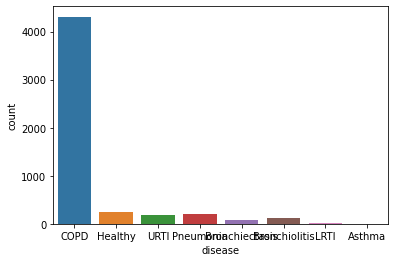

In [72]:
sns.countplot(train.disease)

In [30]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
ytrain=le.fit_transform(ytrain)
yval=le.transform(yval)

In [31]:
def getFeatures(path):
    soundArr,sample_rate=lb.load(path)
    mfcc=lb.feature.mfcc(y=soundArr,sr=sample_rate)
    cstft=lb.feature.chroma_stft(y=soundArr,sr=sample_rate)
    mSpec=lb.feature.melspectrogram(y=soundArr,sr=sample_rate)

    return mfcc,cstft,mSpec

In [ ]:
import librosa as lb
import soundfile as sf
from tqdm import tqdm
root='./processed_audio_files/'
mfcc,cstft,mSpec=[],[],[]

for idx,row in tqdm(val.iterrows()):
    path=root + row['filename']
    a,b,c=getFeatures(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)
    
mfcc_val=np.array(mfcc)
cstft_val=np.array(cstft)
mSpec_val=np.array(mSpec)

In [ ]:
root='./processed_audio_files/'
mfcc,cstft,mSpec=[],[],[]

for idx,row in tqdm(train.iterrows()):
    path=root + row['filename']
    a,b,c=getFeatures(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)
    # tone.append(d)
    # specCen.append(e)
    
mfcc_train=np.array(mfcc)
cstft_train=np.array(cstft)
mSpec_train=np.array(mSpec)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

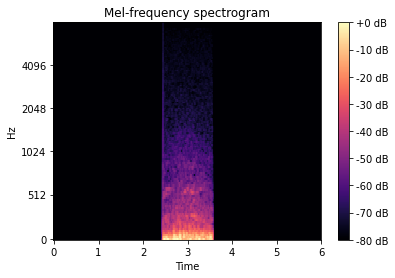

In [41]:
fig, ax = plt.subplots()
soundArr,sample_rate=lb.load(root + Xtrain.iloc[0].filename)
S_dB = librosa.power_to_db(mSpec_train[0], ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sample_rate,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [42]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00001,mode='min')
]

In [59]:
mfcc_input=keras.layers.Input(shape=(20,259,1),name="mfccInput")
x=tf.keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(mfcc_input)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Activation(keras.activations.relu)(x)
x=tf.keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=tf.keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Activation(keras.activations.relu)(x)
x=tf.keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=tf.keras.layers.Conv2D(96,2,padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Activation(keras.activations.relu)(x)
x=tf.keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=tf.keras.layers.Conv2D(128,2,padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Activation(keras.activations.relu)(x)
mfcc_output=tf.keras.layers.GlobalMaxPooling2D()(x)

mfcc_model=tf.keras.Model(mfcc_input, mfcc_output, name="mfccModel")

In [60]:
mfcc_train.shape

(5173, 20, 259)

In [61]:
mfcc_model.summary()

Model: "mfccModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mfccInput (InputLayer)      [(None, 20, 259, 1)]      0         
                                                                 
 conv2d_11 (Conv2D)          (None, 20, 87, 32)        832       
                                                                 
 batch_normalization_11 (Bat  (None, 20, 87, 32)       128       
 chNormalization)                                                
                                                                 
 activation_11 (Activation)  (None, 20, 87, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 10, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 10, 22, 64)        18

In [62]:
croma_input=tf.keras.layers.Input(shape=(12,259,1),name="cromaInput")
x=tf.keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(croma_input)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Activation(keras.activations.relu)(x)
x=tf.keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=tf.keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Activation(keras.activations.relu)(x)
x=tf.keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=tf.keras.layers.Conv2D(96,2,padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Activation(keras.activations.relu)(x)
x=tf.keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=tf.keras.layers.Conv2D(128,2,padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Activation(keras.activations.relu)(x)
croma_output=tf.keras.layers.GlobalMaxPooling2D()(x)

croma_model=tf.keras.Model(croma_input, croma_output, name="cromaModel")

In [63]:
croma_model.summary()

Model: "cromaModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cromaInput (InputLayer)     [(None, 12, 259, 1)]      0         
                                                                 
 conv2d_15 (Conv2D)          (None, 12, 87, 32)        832       
                                                                 
 batch_normalization_15 (Bat  (None, 12, 87, 32)       128       
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 12, 87, 32)        0         
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 6, 43, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 6, 22, 64)         1

In [64]:
mSpec_input=tf.keras.layers.Input(shape=(128,259,1),name="mSpecInput")
x=tf.keras.layers.Conv2D(32,5,strides=(2,3),padding='same')(mSpec_input)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Activation(keras.activations.relu)(x)
x=tf.keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=tf.keras.layers.Conv2D(64,3,strides=(2,2),padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Activation(keras.activations.relu)(x)
x=tf.keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=tf.keras.layers.Conv2D(96,2,padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Activation(keras.activations.relu)(x)
x=tf.keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=tf.keras.layers.Conv2D(128,2,padding='same')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Activation(keras.activations.relu)(x)
mSpec_output=tf.keras.layers.GlobalMaxPooling2D()(x)

mSpec_model=keras.Model(mSpec_input, mSpec_output, name="mSpecModel")

In [65]:
mSpec_model.summary()

Model: "mSpecModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mSpecInput (InputLayer)     [(None, 128, 259, 1)]     0         
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 87, 32)        832       
                                                                 
 batch_normalization_19 (Bat  (None, 64, 87, 32)       128       
 chNormalization)                                                
                                                                 
 activation_19 (Activation)  (None, 64, 87, 32)        0         
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 32, 43, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 16, 22, 64)        1

In [66]:
input_mfcc=tf.keras.layers.Input(shape=(20,259,1),name="mfcc")
mfcc=mfcc_model(input_mfcc)

input_croma=tf.keras.layers.Input(shape=(12,259,1),name="croma")
croma=croma_model(input_croma)

input_mSpec=tf.keras.layers.Input(shape=(128,259,1),name="mspec")
mSpec=mSpec_model(input_mSpec)


concat=tf.keras.layers.concatenate([mfcc,croma,mSpec])
hidden=tf.keras.layers.Dropout(0.2)(concat)
hidden=tf.keras.layers.Dense(50,activation='relu')(concat)
hidden=tf.keras.layers.Dropout(0.3)(hidden)
hidden=tf.keras.layers.Dense(25,activation='relu')(hidden)
hidden=tf.keras.layers.Dropout(0.3)(hidden)
output=tf.keras.layers.Dense(8,activation='softmax')(hidden)

net=tf.keras.Model([input_mfcc,input_croma,input_mSpec], output, name="Net")

In [67]:
net.summary()

Model: "Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mfcc (InputLayer)              [(None, 20, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 croma (InputLayer)             [(None, 12, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 mspec (InputLayer)             [(None, 128, 259, 1  0           []                               
                                )]                                                              

In [68]:
tf.keras.utils.plot_model(net, "net.png", show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [69]:
from keras import backend as K
net.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
K.set_value(net.optimizer.learning_rate, 0.001)

In [70]:
history=net.fit(
    {"mfcc":mfcc_train,"croma":cstft_train,"mspec":mSpec_train},
    ytrain,
    validation_data=({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val},yval),
    epochs=100,verbose=1,
    callbacks=my_callbacks
)

Epoch 1/100
162/162 [==============================] - 9s 35ms/step - loss: 0.7140 - accuracy: 0.7997 - val_loss: 0.5341 - val_accuracy: 0.8330 - lr: 0.0010
Epoch 2/100
162/162 [==============================] - 5s 32ms/step - loss: 0.4981 - accuracy: 0.8363 - val_loss: 0.4894 - val_accuracy: 0.8400 - lr: 0.0010
Epoch 3/100
162/162 [==============================] - 5s 31ms/step - loss: 0.4411 - accuracy: 0.8428 - val_loss: 0.4613 - val_accuracy: 0.8330 - lr: 0.0010
Epoch 4/100
162/162 [==============================] - 5s 32ms/step - loss: 0.4044 - accuracy: 0.8527 - val_loss: 0.3386 - val_accuracy: 0.8638 - lr: 0.0010
Epoch 5/100
162/162 [==============================] - 5s 32ms/step - loss: 0.3834 - accuracy: 0.8575 - val_loss: 0.4621 - val_accuracy: 0.8614 - lr: 0.0010
Epoch 6/100
162/162 [==============================] - 5s 31ms/step - loss: 0.3734 - accuracy: 0.8556 - val_loss: 0.3549 - val_accuracy: 0.8719 - lr: 0.0010
Epoch 7/100
162/162 [==============================] - 5s 

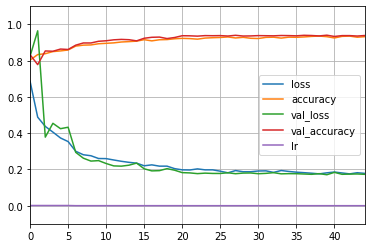

In [55]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(-0.1,1.1)
plt.show()

In [56]:
net.evaluate({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val},yval)

54/54 [==============================] - 1s 10ms/step - loss: 0.1730 - accuracy: 0.9391


[0.17303185164928436, 0.939130425453186]

In [57]:
net.save("my_model")

INFO:tensorflow:Assets written to: my_model/assets


In [58]:
net.save("my_model.h5")

In [84]:
net.predict({"mfcc": np.expand_dims(mfcc_val[10], axis=0),
             "croma":np.expand_dims(cstft_val[10], axis=0),
             "mspec":np.expand_dims(mSpec_val[10], axis=0)})

array([[2.5136555e-07, 8.1530438e-08, 2.8480069e-06, 1.3769987e-02,
        3.6941303e-03, 2.8858037e-07, 9.8251843e-01, 1.4084862e-05]],
      dtype=float32)

(1, 1725, 128, 259)